# Experimental notebook for noise levels and MNIST Digits Data

In [6]:
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent))

import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
from src.get_mnist import (get_mnist_raw, get_mnist_torch)

In [7]:
train_images, train_labels, test_images, test_labels = get_mnist_raw(
    data_dir=str(Path.cwd().parent / 'mnist_data')
)

print(f"\n✓ Loaded from mnist_data directory!")
print(f"Train images: {train_images.shape}, dtype: {train_images.dtype}")
print(f"Train labels: {train_labels.shape}, dtype: {train_labels.dtype}")
print(f"Test images: {test_images.shape}")
print(f"Test labels: {test_labels.shape}")
print(f"Image value range: [{train_images.min():.3f}, {train_images.max():.3f}]")
print(f"Number of classes: {train_labels.max().item() + 1}")

print(f"\nLabel mapping: Digits 0-9")

Loading from mnist_data directory...
  Train images: /Users/brianrapanan/966-project/mnist_data/MNIST/raw/train-images-idx3-ubyte
  Train labels: /Users/brianrapanan/966-project/mnist_data/MNIST/raw/train-labels-idx1-ubyte
  Test images: /Users/brianrapanan/966-project/mnist_data/MNIST/raw/t10k-images-idx3-ubyte
  Test labels: /Users/brianrapanan/966-project/mnist_data/MNIST/raw/t10k-labels-idx1-ubyte
Loaded: Train torch.Size([60000, 28, 28]), Test torch.Size([10000, 28, 28])
Train: torch.Size([60000, 28, 28]), torch.Size([60000])
Test: torch.Size([10000, 28, 28]), torch.Size([10000])

✓ Loaded from mnist_data directory!
Train images: torch.Size([60000, 28, 28]), dtype: torch.float32
Train labels: torch.Size([60000]), dtype: torch.int64
Test images: torch.Size([10000, 28, 28])
Test labels: torch.Size([10000])
Image value range: [0.000, 1.000]
Number of classes: 10

Label mapping: Digits 0-9


Image shape: torch.Size([28, 28])
Label: 5 (digit 5)


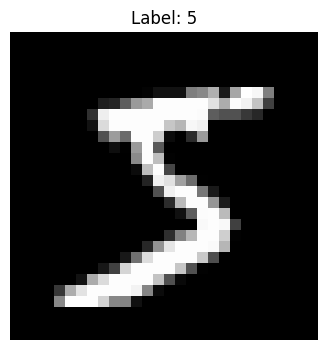

In [8]:
idx = 0
image = train_images[idx]  # Shape: (28, 28) - already normalized
label = train_labels[idx]  # Shape: () - scalar tensor

print(f"Image shape: {image.shape}")
print(f"Label: {label.item()} (digit {label.item()})")

plt.figure(figsize=(4, 4))
plt.imshow(image, cmap='gray')
plt.title(f'Label: {label.item()}')
plt.axis('off')
plt.show()

In [9]:
class MNISTDataset(Dataset):
    """Dataset that works with loaded PyTorch tensors"""
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        
        if len(image.shape) == 2:
            image = image.unsqueeze(0)
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

train_dataset = MNISTDataset(train_images, train_labels)
test_dataset = MNISTDataset(test_images, test_labels)


transform = transforms.Compose([
    transforms.RandomRotation(10),  # Random rotation
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Random translation
    # Add more transforms as needed
])

train_dataset_augmented = MNISTDataset(train_images, train_labels, transform=transform)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 60000
Test dataset size: 10000


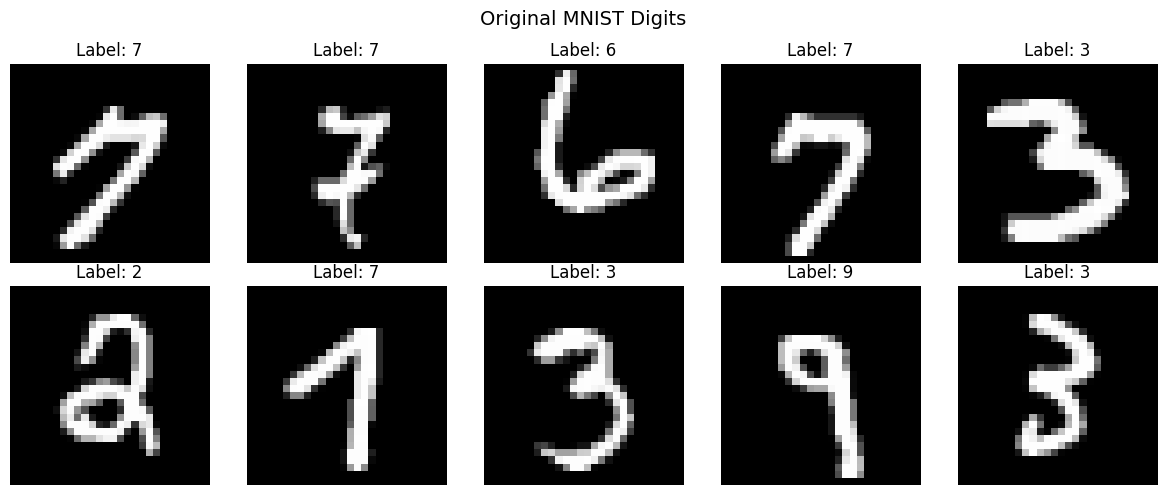

In [10]:
def visualize_samples(dataset, num_samples=10, title="MNIST Samples"):
    fig, axes = plt.subplots(2, 5, figsize=(12, 5))
    axes = axes.flatten()
    
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    
    for i, idx in enumerate(indices):
        image, label = dataset[idx]
        
        if isinstance(image, torch.Tensor):
            img = image.squeeze().numpy()
        else:
            img = image.squeeze()
        
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f'Label: {label.item()}')
        axes[i].axis('off')
    
    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()

visualize_samples(train_dataset, num_samples=10, title="Original MNIST Digits")

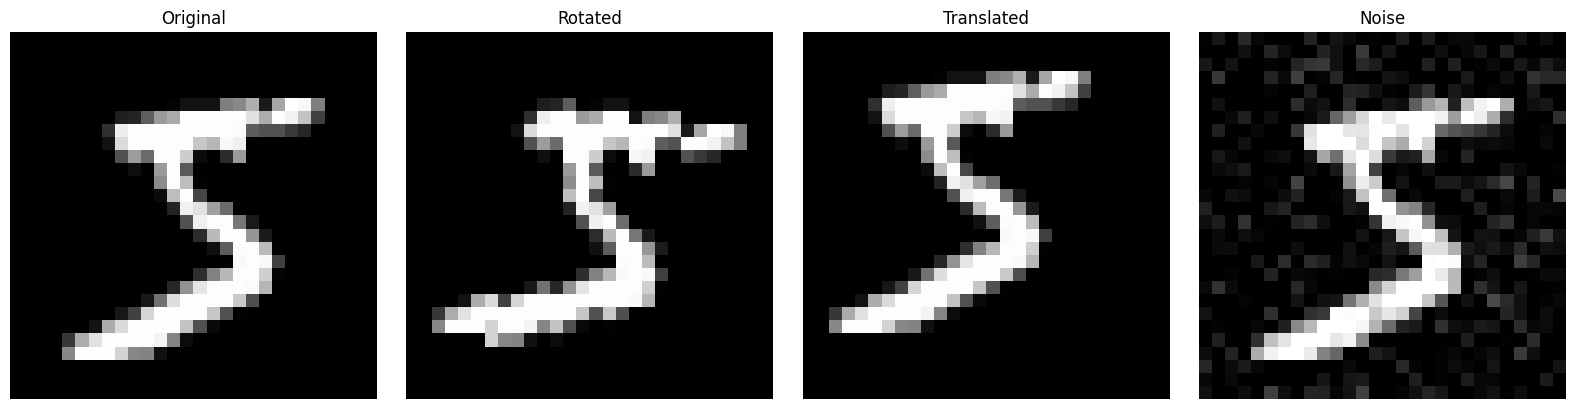

In [11]:
transform_examples = {
    'Original': transforms.Compose([]),
    'Rotated': transforms.Compose([transforms.RandomRotation(15)]),
    'Translated': transforms.Compose([transforms.RandomAffine(degrees=0, translate=(0.2, 0.2))]),
    'Noise': transforms.Compose([
        transforms.Lambda(lambda x: torch.clamp(x + torch.randn_like(x) * 0.1, 0, 1))
    ]),
}

fig, axes = plt.subplots(1, 4, figsize=(16, 4))
original_image = train_images[0]  # Shape: (28, 28)

if len(original_image.shape) == 2:
    original_image = original_image.unsqueeze(0)

for i, (name, transform) in enumerate(transform_examples.items()):
    transformed = transform(original_image)
    # Remove channel dimension for visualization
    img = transformed.squeeze().numpy()
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(name)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# Experiment with blur kernels

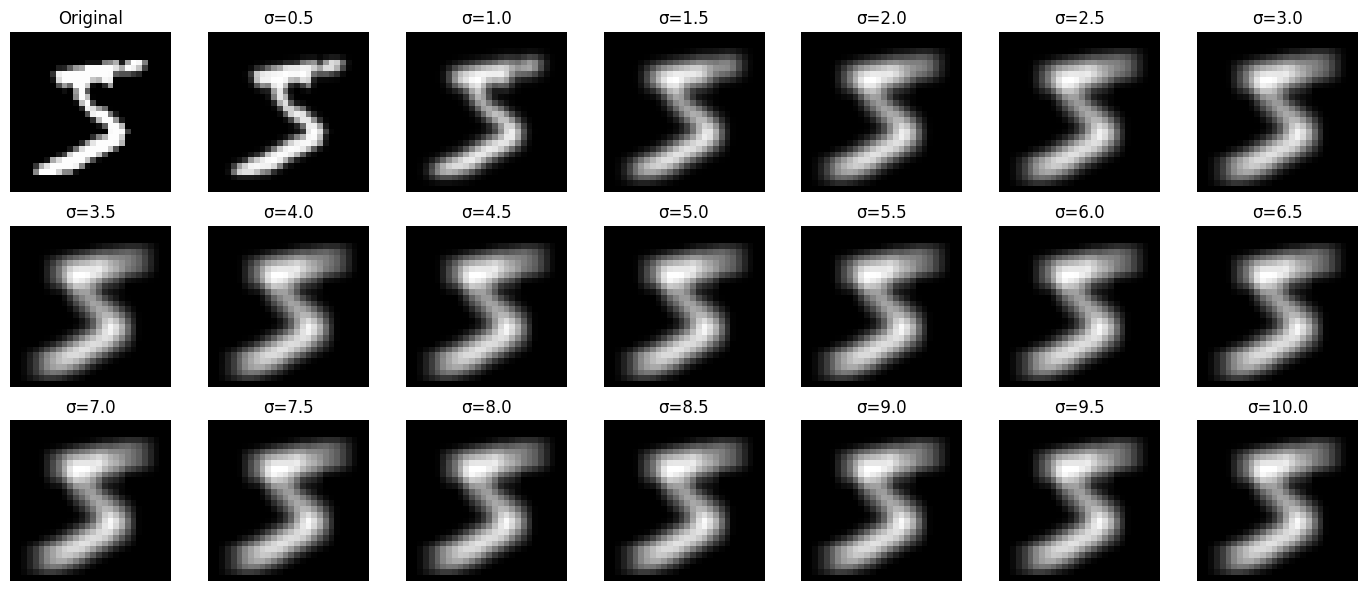

In [12]:
sigmas = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0, 8.5, 9.0, 9.5, 10.0]
img = train_images[0].unsqueeze(0)  # Get first image and add channel dimension: (1, 28, 28)

# Calculate grid dimensions for a square-like layout
total_images = len(sigmas) + 1  # 1 original + 20 blurred
n_cols = 7
n_rows = (total_images + n_cols - 1) // n_cols  # Ceiling division

plt.figure(figsize=(14, 6))

# Original image
plt.subplot(n_rows, n_cols, 1)
plt.imshow(img.squeeze().numpy(), cmap='gray')
plt.title('Original')
plt.axis('off')

# Blurred images
for i, sigma in enumerate(sigmas):
    blur_kernel = transforms.GaussianBlur(kernel_size=5, sigma=sigma)
    blurred_img = blur_kernel(img)
    
    plt.subplot(n_rows, n_cols, i + 2)  # i+2 because first subplot is original
    plt.imshow(blurred_img.squeeze().numpy(), cmap='gray')
    plt.title(f'σ={sigma}')
    plt.axis('off')

plt.tight_layout()
plt.show()

# Test Pixelate

In [13]:
class Pixelate(nn.Module):
    def __init__(self, downscale_factor=4.0):
        """
        downscale_factor can be float — e.g., 2.5, 3.7, 5.2
        Larger = more pixelated.
        """
        super().__init__()
        self.downscale_factor = float(downscale_factor)

    def forward(self, img):
        """
        img: (C, H, W) float tensor
        """
        C, H, W = img.shape
        
        h_small = max(1, int(round(H / self.downscale_factor)))
        w_small = max(1, int(round(W / self.downscale_factor)))

        img_small = torch.nn.functional.interpolate(
            img.unsqueeze(0), size=(h_small, w_small), mode="nearest"
        )
        img_big = torch.nn.functional.interpolate(
            img_small, size=(H, W), mode="nearest"
        )
        return img_big.squeeze(0)


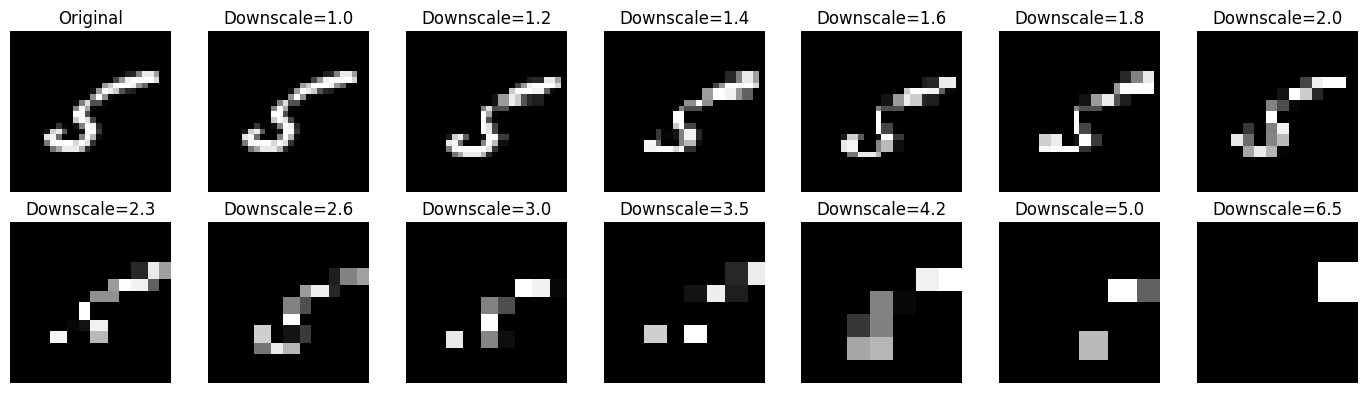

In [14]:
downscales = [1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.3, 2.6, 3.0, 3.5, 4.2, 5.0, 6.5]
img = train_images[11].unsqueeze(0)  

# Calculate grid dimensions for a square-like layout
total_images = len(downscales) + 1  # 1 original + 13 pixelated
n_cols = 7
n_rows = (total_images + n_cols - 1) // n_cols  # Ceiling division

plt.figure(figsize=(14, 4))

# Original image
plt.subplot(n_rows, n_cols, 1)
plt.imshow(img.squeeze().numpy(), cmap='gray')
plt.title('Original')
plt.axis('off')

# Pixelated images
for i, downscale in enumerate(downscales):
    pixelate = Pixelate(downscale)
    pixelated_img = pixelate(img)
    
    plt.subplot(n_rows, n_cols, i + 2)  # i+2 because first subplot is original
    plt.imshow(pixelated_img.squeeze().numpy(), cmap='gray')
    plt.title(f'Downscale={downscale}')
    plt.axis('off')

plt.tight_layout()
plt.show()

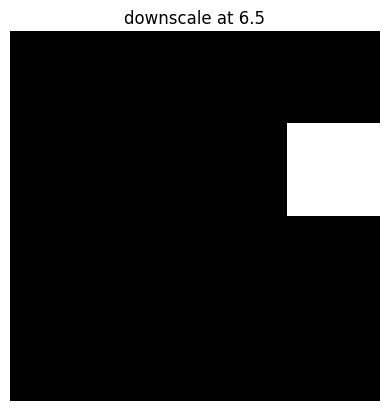

In [16]:
plt.figure()
plt.imshow(pixelated_img.squeeze().numpy(), cmap='gray')
plt.axis('off')
plt.title('downscale at 6.5')
plt.show()

# Pixelation looks better suited for this data and experiment goal, use MNIST